In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics as st
from statistics import median, mean
from multiprocessing import Process
import requests
from multiprocessing.pool import ThreadPool as Pool
import timeit

# Intro

My plan is to work my way up to timing the speed of finding a maximum using a variable number of processors.

My plan:
1. Learn how to use python statistics on dataframe rows
2. Define a function that find the max of medians on dataframe
3. Define a function or find an inbuilt function to split a dataframe (by row)
4. Learn the timeit module
5. Learn the multiprocessing python package 
6. Use the the multiprocessing and defined functions, Log relative times of finding the global maximum of medians based on number of processes
7. graph
8. conclusion

..........................................................................................

## The Dataframe

Uses random numbers to fill dataframe

In [2]:
NumColumns = 100
NumRows = 1000

df = pd.DataFrame(np.random.randn(NumRows,NumColumns)) #row, columns

## 1. Practicing Python statistics on Dataframe Rows
Simple statistical data on data frame

In [3]:
print("Median: " + str(median(df[0])))
print("Mean:   " + str(mean(df[0])))
print("Max:    " + str(max(df[0])))
print("Min: " + str(min(df[0])))

#plt.table(cellText=df.values, colLabels=df.columns, loc='center')
#df.describe()

Median: 0.07371514671384577
Mean:   0.029012862305744277
Max:    3.5553805560110083
Min: -4.480760533516666


## 2. Defining a function that gets maximum from all medians of rows in a 'chunk'

First get a list of medians from the rows, then get a single maximum of those medians. 

note:
`chunks` are meant to be smaller sections of dataframes that are split apart for multiprocessing

In [4]:
def chunkMax(chunk) -> float:
    #Initializing Max to first element 
    chunkMax = median(chunk.iloc[0])
    
    for i in range(1, len(chunk)) :
        med = median(chunk.iloc[i])
        if (chunkMax < med):
            chunkMax = med
    return chunkMax

### Testing the 'chunkMax' function

In [5]:
testdf = pd.DataFrame(np.random.randn(4,5))

testdfMax = chunkMax(testdf)
print("my functions max for all rows: ")
print(testdfMax)
print("\n")
print("median for each row, sorted: ")
medians = [median(testdf.iloc[0]),median(testdf.iloc[1]),median(testdf.iloc[2]),median(testdf.iloc[3])]

medians.sort(reverse=1)
print(medians)

my functions max for all rows: 
0.8290861150856286


median for each row, sorted: 
[0.8290861150856286, 0.5229560702209297, -0.38137497418510724, -0.66455549921607]


## 3. Splitting a python dataframe

This is the best way I found to split a dataframe by row. I have never done this, so there likely a better way. However, I didn't find any inbuilt functions

In [6]:
#Splitting the dataframe into 2 parts
df1 = df.iloc[:int(NumRows/2),:] # using number of rows as defined for the main dataframe
df2 = df.iloc[int(NumRows/2):,:]

In [7]:
#splitting row and using my find max median of chunk function to find the max of both smaller chunks
df1Max = chunkMax(df1)
df2Max = chunkMax(df2)
print(df1Max)
print(df2Max)

0.39354426250367314
0.42633124104096964


### Function to split dataframe into variable number of chunks

Is there a better way to do this? Perhaps a built in function in multiprocessing to split apart a dataframe / list automatically?

In [8]:
def splitdf(df, numChunks):
    rowsPerChunk = int(len(df) / numChunks)
    
    chunkArray = []
    #iterate through the number of chunks, assign those chunks indices
    for i in range(0, numChunks - 1) :
        beginInd = rowsPerChunk*i
        endInd = rowsPerChunk*i+1
        
        chunkArray.append(df.iloc[beginInd:endInd]) #this takes rows from index
        
    chunkArray.append(df.iloc[rowsPerChunk*(numChunks-1):]) #makes sure no rows left out due to rounding at end
    
    return chunkArray

#### Testing result from this function

making sure that no rows or number were left out within the 'splitdf' function 

In [9]:
chunks = splitdf(df, 3)

chunkMaxList = [chunkMax(chunk) for chunk in chunks]


print("this is the global maximum by using one chunk and no multiprocessing: ")
print(chunkMax(df))

print("this is the gobal maximum using three chunks and multiprocessing: ")
print(max(chunkMaxList))

this is the global maximum by using one chunk and no multiprocessing: 
0.42633124104096964
this is the gobal maximum using three chunks and multiprocessing: 
0.3030617261483246


## 4. Practicing using timeit python module

### Timing basic chunk max function

In [10]:
#initial time
begin = timeit.default_timer()
res = chunkMax(df)
#end time
end = timeit.default_timer()

elapsed = round((end - begin), 3)
print(f"Elapsed time: {elapsed} ms")

Elapsed time: 0.056 ms


## 5. Practicing using multiprocessing package

In [11]:
pool = Pool(3)
chunkMaxes = []
for result in pool.imap_unordered(chunkMax, chunks):
    chunkMaxes.append(result)
    
print("global maximum by using one chunk, no multiprocessing: ")
print(chunkMax(df))
print("global maximum by using three chunks and multiprocessing: ")
print (max(chunkMaxes))

global maximum by using one chunk, no multiprocessing: 
0.42633124104096964
global maximum by using three chunks and multiprocessing: 
0.3030617261483246


### 6. Timing Speeds of multiprocessing based on processes allocated

In [12]:
begin = timeit.default_timer()

chunks = splitdf(df, 3)
pool = Pool(3)
chunkMaxes = []
for result in pool.imap_unordered(chunkMax, chunks):
    chunkMaxes.append(result)

end = timeit.default_timer()

elapsed = round((end - begin), 3)
print("time with 3 processes: ")
print(f"Elapsed time: {elapsed} ms")

time with 3 processes: 
Elapsed time: 0.021 ms


In [13]:
begin = timeit.default_timer()

chunks = splitdf(df, 12)
pool = Pool(12)
chunkMaxes = []
for result in pool.imap_unordered(chunkMax, chunks):
    chunkMaxes.append(result)

end = timeit.default_timer()

elapsed = round((end - begin), 3)
print("time with 12 processes: ")
print(f"Elapsed time: {elapsed} ms")

time with 12 processes: 
Elapsed time: 0.012 ms


## Graphing

putting it all together, with a graph to show dropoff of time versus processes

[0.057, 0.051, 0.029, 0.021, 0.017, 0.014, 0.018, 0.021, 0.013, 0.013, 0.012, 0.012, 0.011, 0.011, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.011, 0.011, 0.011, 0.011, 0.01, 0.011, 0.011, 0.012, 0.013, 0.012, 0.012, 0.012, 0.013, 0.013, 0.014, 0.014, 0.013, 0.013, 0.014, 0.014, 0.014, 0.015, 0.014, 0.015, 0.014, 0.015, 0.015, 0.016, 0.016]


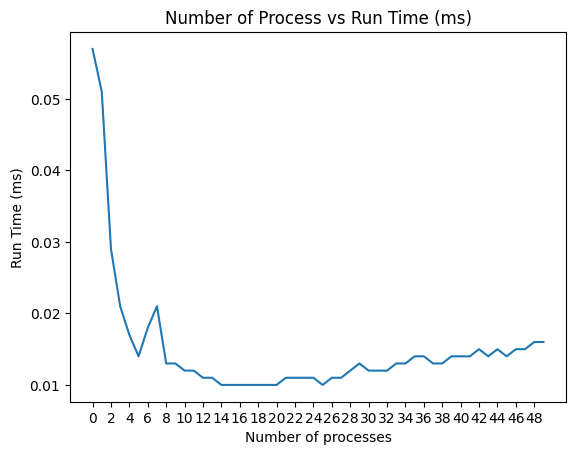

In [14]:
maxProcesses = 50
times = []

# Log time for case with no multiprocessing
begin = timeit.default_timer()
res = chunkMax(df)
end = timeit.default_timer()

times.append(round((end - begin), 3))

# For each number of processes, run the find max program with multiprocessing, log the time to do so
for i in range(1, maxProcesses):

    begin = timeit.default_timer()

    chunks = splitdf(df, i)
    pool = Pool(i)
    chunkMaxes = []
    for result in pool.imap_unordered(chunkMax, chunks):
        chunkMaxes.append(result)
    
    end = timeit.default_timer()

    times.append(round((end - begin), 3))

print(times)
processNums = list(range(0, maxProcesses))

plt.plot(processNums, times)
plt.xlabel('Number of processes')#, fontweight='bold', color = 'orange', fontsize='17', horizontalalignment='center')
plt.ylabel('Run Time (ms)')
plt.title("Number of Process vs Run Time (ms)")
plt.xticks(np.arange(0, maxProcesses, 2))
plt.show()

## 8. Conclusion

This closely maps to what I have been recently learning both on my own and in studying. Multiprocessing only helps as much as the part that is parallelizable consitutes the problem.

Personal notes:

This was a very fun challenge for me, as I have been exposed to python for datascience often through my studies in biology, but never have I really tackled a challenge using python before, and now I realize why python is used for data science : the availability of science and data oriented packages, and scripting.

Also, as far as time spent, this was about 3 hours worth of work, mainly in learning the python packages and looking up how to do certain tasks using python

resources: 
- pandas basics
    - [What is Pandas? Why and How to Use Pandas in Python](https://www.youtube.com/watch?v=dcqPhpY7tWk)
- matplot lib
    - [what is Matplotlib in Python?](https://www.activestate.com/resources/quick-reads/what-is-matplotlib-in-python-how-to-use-it-for-plotting/)
    - [matplotlib.pyplot.plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html)
- splitting a dataframe
    - [How to Split Pandas DataFrame?](https://sparkbyexamples.com/pandas/how-to-split-pandas-dataframe/#:~:text=groupby()%20function%20is%20used,column%20that%20has%20unique%20values.)
- timit module
    - [how to measure elapsed time in python](https://www.geeksforgeeks.org/how-to-measure-elapsed-time-in-python/) (it's geeks for geeks, unfortunately)
    - [timit docs](https://docs.python.org/3/library/timeit.html)